# Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
from transformers import pipeline, AutoTokenizer

In [2]:
import json
import copy

# Load your usual SpaCy model (one of SpaCy English models)
import spacy
import re
nlp = spacy.load('en_core_web_lg')

# Add neural coref to SpaCy's pipeline
import neuralcoref
neuralcoref.add_to_pipe(nlp)

# Data Generation / Manipulation Functions

In [ ]:
class DocProcessor:
    def __init__(self, text):
        self.original_text = text
        
    def clean_wikitext(text):

In [3]:
def clean_wikitext(text):
    cleaned = re.sub(r'\[.{1,3}\]', '', text)
    cleaned = re.sub(r' \(([^\)]*[^\)]*?)\)', '', cleaned)
    return cleaned

def print_clusters(items):
    for i in items:
        print(i)
    print()
        
def get_people_ents(span):
    return [e for e in span.ents if e.label_ == 'PERSON']

# gets a list tuples, where each tuple contains two list - l1 and l2
# where l1 represents all coreferred entities
# where l2 represents its coreferences (pronouns)
# can have multiple in l1 due to multiple people and "theys"
def get_cluster_pairs(spacy_doc):
    clusters = spacy_doc._.coref_clusters
    clusters = [c for c in clusters if len(get_people_ents(c.main)) > 0]
    paired_clusters = [(get_people_ents(c.main), c.mentions[1:]) for c in clusters]
    return paired_clusters

def flatten_cluster_pairs(pairs):
    return sum([p[0] + p[1] for p in pairs], []) # flatten arary of tupled mentions

def get_relevant_annotations(spacy_doc):
    entities = get_people_ents(spacy_doc)
    flat_pairs = flatten_cluster_pairs(get_cluster_pairs(spacy_doc))
    
    for ent in flat_pairs:
        if ent not in entities:
            entities.append(ent)
            
    return entities

def create_label_annotations(text):
    global nlp
    spacy_doc = nlp(text)
    # cluster_pairs = get_cluster_pairs(spacy_doc)
    # flat = flatten_cluster_pairs(cluster_pairs)
    annotations = get_relevant_annotations(spacy_doc)
    
    res = {'data': {'text': text}, 'predictions': [{'result': []}]}
    to_add = res['predictions'][0]['result']
    
    template = {
        'from_name': 'label',
        'to_name': 'txt-99',
        'type': 'labels',
    }
    
    for ent in annotations:
        template['value'] = {
            'start': ent.start_char,
            'end': ent.end_char,
            'text': ent.text,
            'labels': ['entity']
        }
        
        to_add.append(copy.deepcopy(template))
        
    return res
    
# clean_wikitext('Maria "Maja" Einstein (18 November 1881 – 25 June 1951) and her older brother, Albert, were the two children of Hermann Einstein and Pauline Einstein (née Koch), who had moved from Ulm to Munich in June 1881, when Albert was one.[14] There Hermann and his brother Jakob had founded Einstein & Cie., an electrical ')

In [4]:
text = '''
Smith was born on September 25, 1968, in Philadelphia, to Caroline (née Bright), a Philadelphia school board administrator, and Willard Carroll Smith Sr.,[14][15] a U.S. Air Force veteran[16] and refrigeration engineer. His mother graduated from Carnegie Mellon University.[17] He grew up in West Philadelphia's Wynnefield neighborhood,[18] and was raised Baptist.[19] He has an older sister named Pamela and two younger siblings, twins Harry and Ellen.[18] Smith attended Our Lady of Lourdes, a private Catholic elementary school in Philadelphia,[20] followed by Overbrook High School.[21] His parents separated when he was 13,[22] but did not actually divorce until around 2000.[23] Smith began rapping at the age of 12. When his grandmother found a notebook of his lyrics, which he described as containing "all [his] little curse words", she wrote him a note on a page in the book, which read, "Dear Willard, truly intelligent people do not have to use words like this to express themselves. Please show the world that you're as smart as we think you are". Smith said that this influenced his decision not to use profanity in his music.[24]
'''
xyz = nlp(clean_wikitext(text))
crc = xyz._.coref_clusters
crc

[
 Smith: [
 Smith, His, He, He, Smith, His, he, Smith, his, his, he, him, Smith, his, his],
 Philadelphia: [Philadelphia, Philadelphia, West Philadelphia's, Philadelphia],
 his grandmother: [his grandmother, she],
 truly intelligent people: [truly intelligent people, themselves]]

In [5]:
# # Import generic wrappers
# from transformers import AutoModel, AutoTokenizer 


# # Define the model repo
# model_name = "SpanBERT/spanbert-base-cased" 


# # Download pytorch model
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)


# # Transform input tokens 
# inputs = tokenizer("Hello world!", return_tensors="pt")

# # Model apply
# outputs = model(**inputs)

In [6]:
# # Transform input tokens 
# inputs = tokenizer("Smith was born on September 25, 1968, in Philadelphia, to Caroline (née Bright), a Philadelphia school board administrator, and Willard Carroll Smith Sr.,[14][15] a U.S. Air Force veteran[16] and refrigeration engineer. His mother graduated from Carnegie Mellon University.[17]", return_tensors="pt")

# # Model apply
# outputs = model(**inputs)
# outputs

In [378]:
with open('docs_wiki.txt') as f:
    txt_content = f.read()

with open('docs_wiki_clean.txt', 'w') as out:
    out.write(clean_wikitext(txt_content))

# Output Model Predictions for documents to Label Studio formatting

In [382]:
with open('docs_wiki.txt') as f:
    txt_content = f.read()

docs = txt_content.split('\n***\n')
docs = [clean_wikitext(d.strip()) for d in docs if d != '']

with open('docs_wiki_clean.txt', 'w') as out:
    out.write('\n\n***\n\n'.join(docs))

data = []

print(docs[0])

for doc in docs:
    data.append(create_label_annotations(doc))

with open('data.json', 'w') as f:
    json.dump(data, f)

Chan was born on 7 April 1954 in Hong Kong as Chan Kong-sang to Charles and Lee-Lee Chan, refugees from the Chinese Civil War. His parents were so poor they had to borrow money from friends to pay the doctor. His parents nicknamed him Pao-pao because the energetic child was always rolling around. His parents worked for the French ambassador in Hong Kong, and Chan spent his formative years within the grounds of the consul's residence in the Victoria Peak district.

In 1982, Chan married Joan Lin, a Taiwanese actress. Their son, singer and actor Jaycee Chan, was born that same year. Chan's extra-marital affair with Elaine Ng Yi-Lei produced a daughter by the name of Etta Ng Chok Lam, born on 18 January 1999. It turned into a scandal within the media. Although he reportedly gave Elaine 70,000 HK dollars each month for her living expenses and 600,000 HK dollars when she moved to Shanghai, the transactions were later claimed to be nonexistent by her lawyer. Despite regretting the results of

# Data Models / Classes

In [383]:
class Entity:
    def __init__(self, text, start=-1, end=-1, ID='N/A'):
        self.text = text
        self.ID = ID
        self.start = start
        self.end = end
        str_repr_end = f' ({self.ID[:3]})' if self.ID != 'N/A' else ''
        self.str_repr = f'{self.text}{str_repr_end}'
        
    def __eq__(self, e2):
        return self.text == e2.text and self.start == e2.start and self.end == e2.end
    
    def __hash__(self):
        return hash((self.text, self.start, self.end))
    
    def __str__(self):
        return self.str_repr
    
    def __repr__(self):
        return self.str_repr
    
# Relation labels are of the format:
# 'bidirectional', 'f', 'b'
# :
# 'parent-child', 'son-of', etc.
class Relation:
    def __init__(self, e1, e2, label='N/A:N/A'):
        self.label = label.split(':')[1]
        self.label_type = label.split(':')[0]
        
        if self.label_type != 'b':
            self.e1 = e1
            self.e2 = e2
        else:
            self.e1 = e2
            self.e2 = e1
        
    def __str__(self):
        if self.label_type == 'bidirectional':
            return f'[{self.label}] {str(self.e1)} <---> {str(self.e2)}'
        else:
            return f'[{self.label}] {str(self.e1)} ---> {str(self.e2)}'
        
    def __repr__(self):
        if self.label_type == 'bidirectional':
            return f'[{self.label}] {str(self.e1)} <---> {str(self.e2)}'
        else:
            return f'[{self.label}] {str(self.e1)} ---> {str(self.e2)}'
        
#     def get_sentence(self, spacy_doc):
#         for s in spacy_doc.sents:
#             if self.entities_in_span(s):
#                 return s.text
        
#     def entities_in_span(self, span):
#         if self.e1.start < span.start_char or self.e1.end > span.end_char:
#             return False
#         if self.e2.start < span.start_char or self.e2.end > span.end_char:
#             return False
#         return True
    
    def get_span(self, text, edge_chars=0):
        if self.e1.start < self.e2.start:
            pre_chars = self.e1.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e1.start]
            post_chars = self.e2.end + edge_chars
            post_chars = text[self.e2.end:post_chars]
            return f'{pre_chars}{text[self.e1.start : self.e2.end]}{post_chars}'
        else:
            pre_chars = self.e2.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e2.start]
            post_chars = self.e1.end + edge_chars
            post_chars = text[self.e1.end:post_chars]
            return f'{pre_chars}{text[self.e2.start : self.e1.end]}{post_chars}'
        
    def get_annotated_span(self, text, e1_func, e2_func, edge_chars=0):
        e1_annotated = e1_func(text[self.e1.start : self.e1.end])
        e2_annotated = e2_func(text[self.e2.start : self.e2.end])
        if self.e1.start < self.e2.start:
            pre_chars = self.e1.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e1.start]
            post_chars = self.e2.end + edge_chars
            post_chars = text[self.e2.end:post_chars]
            return f'{pre_chars}{e1_annotated}{text[self.e1.end : self.e2.start]}{e2_annotated}{post_chars}'
        else:
            pre_chars = self.e2.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e2.start]
            post_chars = self.e1.end + edge_chars
            post_chars = text[self.e1.end:post_chars]
            return f'{pre_chars}{e2_annotated}{text[self.e2.end : self.e1.start]}{e1_annotated}{post_chars}'
        

class DocRelations:
    def __init__(self, doc, with_negatives=False):
        self.text = doc['data']['text']
        # self.spacy_doc = nlp(self.text)
        self.doc_ID = doc['id']
        self.entities = {}
        self.entity_rels = {}
        self.num_entities = 0
        self.num_relations = 0
        
        for ent in doc['annotations'][0]['result']:
            if ent['type'] == 'labels':
                self.num_entities += 1
                val = ent['value']
                self.entities[ent['id']] = Entity(val['text'], val['start'], val['end'], ent['id'])
                
        for ann in doc['annotations'][0]['result']:
            if ann['type'] == 'relation':
                for lab in ann['labels']:
                    ent1 = self.entities[ann['from_id']]
                    ent2 = self.entities[ann['to_id']]
                    rel = Relation(ent1, ent2, lab)
                    
                    self.add_relationship(rel)
                        
        if with_negatives:
            for i in range(self.num_relations):
                new_rel = self.new_negative_rel(inorder=True)
                if new_rel is not None:
                    self.add_relationship(new_rel)
    
    # relation must be of class Relation
    def add_relationship(self, relation):
        self.num_relations += 1
        
        if relation.e1 not in self.entity_rels:
            self.entity_rels[relation.e1] = []
        self.entity_rels[relation.e1].append(relation)

    def are_related(self, e1, e2):
        if e1 in self.entity_rels and e2 in [rel.e2 for rel in self.entity_rels[e1]]:
            return True
        if e2 in self.entity_rels and e1 in [rel.e2 for rel in self.entity_rels[e2]]:
            return True
        return False
                        
    def new_negative_rel(self, inorder=False):
        (e1, e2) = np.random.choice(list(self.entities.values()), size=(2,), replace=False)
        
        iter = 0
        while self.are_related(e1, e2):
            (e1, e2) = np.random.choice(list(self.entities.values()), size=(2,), replace=False)
            iter += 1
            if iter > 50:
                return None
                # print('****\n\nHIGH PROBABILITY OF MAXIMUM RELATIONSHIPS\n\n****')
            
        # guarantees e1 is always before e2 in a span of text
        if inorder:
            if e2.start < e1.start:
                (e1, e2) = (e2, e1)
        
        return Relation(e1, e2, 'n:no-rel')
    
    def get_relationships(self):
        return [subl for top_list in self.entity_rels.values() for subl in top_list]
        
        

# Load up documents from Label Studio into data-rich classes

In [384]:
with open('exported.json', 'r') as f:
    data = json.load(f)

In [167]:
# text = "Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian . She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob. Their mother is of Dutch, English, Irish, and Scottish ancestry, while their father was a third-generation Armenian-American. After their parents divorced in 1991, her mother married again that year, to Bruce Jenner, the 1976 Summer Olympics decathlon winner. Through their marriage, Kim Kardashian gained step-brothers Burton \"Burt\", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner."
# print(text)
# yz = nlp(text)
# sents = [s for s in yz.sents]

In [385]:
test = DocRelations(data[1], with_negatives=True)

In [386]:
print(test.text)
test.get_relationships()

Grace Brewster Murray was born in New York City. She was the eldest of three children. Her parents, Walter Fletcher Murray and Mary Campbell Van Horne, were of Scottish and Dutch descent, and attended West End Collegiate Church. Her great-grandfather, Alexander Wilson Russell, an admiral in the US Navy, fought in the Battle of Mobile Bay during the Civil War.

In 1930 Grace Murray married New York University professor Vincent Foster Hopper; they divorced in 1945. Although she did not marry again, she retained his surname.


[[parent-child] Her (Tj1) <---> Walter Fletcher Murray (wX-),
 [daughter-of] Her (Tj1) ---> Walter Fletcher Murray (wX-),
 [parent-child] Her (Tj1) <---> Mary Campbell Van Horne (etN),
 [daughter-of] Her (Tj1) ---> Mary Campbell Van Horne (etN),
 [no-rel] Her (Tj1) ---> Vincent Foster Hopper (flf),
 [father-of] Walter Fletcher Murray (wX-) ---> Her (Tj1),
 [mother-of] Mary Campbell Van Horne (etN) ---> Her (Tj1),
 [no-rel] Mary Campbell Van Horne (etN) ---> she (Blc),
 [marriage] Grace Murray (aDd) <---> Vincent Foster Hopper (flf),
 [wife-of] Grace Murray (aDd) ---> Vincent Foster Hopper (flf),
 [no-rel] Grace Murray (aDd) ---> she (2fw),
 [husband-of] Vincent Foster Hopper (flf) ---> Grace Murray (aDd),
 [no-rel] Vincent Foster Hopper (flf) ---> she (Blc),
 [no-rel] Grace Brewster Murray (W-k) ---> she (Blc),
 [no-rel] Grace Brewster Murray (W-k) ---> She (Iw0),
 [no-rel] Grace Brewster Murray (W-k) ---> Vincent Foster Hopper (flf),
 [no-rel] Her (TF2) ---> she (2fw),
 [no-rel] Her (

# Convert data from DocRelations to DataFrames for use in transformer training
This is necessary because for different models, DataFrames of varying structure will be needed

In [171]:
def get_bert_data(doc, transform_e1, transform_e2, boundary_chars):
    bert_data = {
        'text': [],
        'relationship': [],
        'type': [],
        'doc_ID': []
    }
    
    for rel in doc.get_relationships():
        bert_data['text'].append(rel.get_annotated_span(doc.text, transform_e1, transform_e2, boundary_chars))
        bert_data['relationship'].append(rel.label)
        bert_data['type'].append(rel.label_type)
        bert_data['doc_ID'].append(doc.doc_ID)
    
    return bert_data

def make_dataset(doc_json, transform_e1, transform_e2, boundary_chars):
    with open('exported.json', 'r') as f:
        docs = json.load(f)

    text = []
    relationships = []
    types = []
    doc_IDs = []
    
    for exported_data in docs:
        doc = DocRelations(exported_data, with_negatives=True)
        doc_data = get_bert_data(doc, transform_e1, transform_e2, boundary_chars)
        text = text + doc_data['text']
        relationships = relationships + doc_data['relationship']
        types = types + doc_data['type']
        doc_IDs = doc_IDs + doc_data['doc_ID']
    
    return pd.DataFrame({
        'text' : text,
        'relationship' : relationships,
        'type' : types,
        'doc_ID': doc_IDs
    })

In [172]:
t_e1 = lambda e: f'[E1] {e} [/E1]'
t_e2 = lambda e: f'[E2] {e} [/E2]'
# t_e1 = lambda e: f'[PERSON1]'
# t_e2 = lambda e: f'[PERSON2]'
boundary_chars = 15
df = make_dataset('exported.json', t_e1, t_e2, boundary_chars)
df

,text,relationship,type,doc_ID
0,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",parent-child,bidirectional,52
1,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",mother-of,f,52
2,"uary 27, 1980, [E2] Rodham [/E2] gave birth to...",daughter-of,b,52
3,daughter whom [E1] they [/E1] named Chelsea. ...,no-rel,n,52
4,daughter whom [E1] they [/E1] named Chelsea. ...,no-rel,n,52
...,...,...,...,...
986,was one. There [E1] Hermann [/E1] and [E2] his...,no-rel,n,4
987,was one. There [E2] Hermann [/E2] and his brot...,brother-of,b,4
988,re Hermann and [E2] his [/E2] brother [E1] Jak...,brother-of,b,4
989,re Hermann and [E1] his [/E1] brother [E2] Jak...,siblings,bidirectional,4


In [173]:
bidirectional = df[df['type'] == 'bidirectional']
no_rel = df[df['type'] == 'n']
max_label = bidirectional.groupby('relationship').count()['text'].max()
display(max_label)
no_rel = no_rel.sample(frac=len(bidirectional)/len(no_rel))
# no_rel = no_rel.sample(max_label)
bino_df = pd.concat([bidirectional, no_rel])
display(bino_df)
display(bino_df['relationship'].value_counts())

87

,text,relationship,type,doc_ID
0,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",parent-child,bidirectional,52
6,"of Park Ridge. [E1] Her [/E1] father, [E2] Hug...",parent-child,bidirectional,51
11,"e had founded. [E1] Her [/E1] mother, [E2] Dor...",parent-child,bidirectional,51
17,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51
19,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51
...,...,...,...,...
536,n Hong Kong as [E1] Chan Kong-sang [/E1] to [E...,no-rel,n,25
444,[E1] Milton Berle [/E1] was born into a Jewish...,no-rel,n,31
603,[E1] Rock [/E1] married Malaak Compton-Rock on...,no-rel,n,21
201,"re Carazo, and [E1] Roy Elwood Cohn [/E1], a U...",no-rel,n,44


no-rel          171
parent-child     87
siblings         42
marriage         42
Name: relationship, dtype: int64

In [174]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
bino_df['numerical'] = le.fit_transform(bino_df['relationship'])
bino_df

,text,relationship,type,doc_ID,numerical
0,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",parent-child,bidirectional,52,2
6,"of Park Ridge. [E1] Her [/E1] father, [E2] Hug...",parent-child,bidirectional,51,2
11,"e had founded. [E1] Her [/E1] mother, [E2] Dor...",parent-child,bidirectional,51,2
17,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51,3
19,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51,3
...,...,...,...,...,...
536,n Hong Kong as [E1] Chan Kong-sang [/E1] to [E...,no-rel,n,25,1
444,[E1] Milton Berle [/E1] was born into a Jewish...,no-rel,n,31,1
603,[E1] Rock [/E1] married Malaak Compton-Rock on...,no-rel,n,21,1
201,"re Carazo, and [E1] Roy Elwood Cohn [/E1], a U...",no-rel,n,44,1


In [175]:
bino_df.to_json('model_dataset.json')

In [176]:
bi_df = bino_df[bino_df['relationship'] != 'no-rel']
bi_df['text'].str.len().mean()

100.9298245614035

# Generate entity rel data from text

In [177]:
MAX_SPAN_LEN = 140

class ParagraphPipeline:
    def __init__(self, paragraph, t_e1=lambda x: f'[E1] {x} [/E1]', t_e2=lambda x: f'[E2] {x} [/E2]', edge_chars=20):
        self.t_e1 = t_e1
        self.t_e2 = t_e2
        self.edge_chars = edge_chars
        self.text = clean_wikitext(paragraph)
        self.spacy_doc = nlp(self.text)
        self.entities = []
        self.rels = []
        ents = get_relevant_annotations(self.spacy_doc)
        
        for e in ents:
            self.entities.append(Entity(e.text, e.start_char, e.end_char))

        clust_pairs = get_cluster_pairs(self.spacy_doc)
        clust_dict = defaultdict(lambda: [])
        
        for refers2, coref in clust_pairs:
            refers2 = [Entity(r2.text, r2.start_char, r2.end_char) for r2 in refers2]
            for c in coref:
                c_ent = Entity(c.text, c.start_char, c.end_char)
                # print(type(refers2[0]))
                clust_dict[c_ent] = clust_dict[c_ent] + refers2
                    
        self.entity_rels = clust_dict

        for i in range(len(self.entities)):
            for j in range(i + 1, len(self.entities)):
                e1 = self.entities[i]
                e2 = self.entities[j]
                span = self.text[e1.start : e2.end]
                if len(span) < MAX_SPAN_LEN:
                    new_rel = Relation(e1, e2)
                    self.rels.append(new_rel)
                    
    def get_annotated_rels(self):
        return [rel.get_annotated_span(self.text, self.t_e1, self.t_e2, self.edge_chars) for rel in self.rels]

                    # print(new_rel.get_annotated_span(self.text, self.t_e1, self.t_e2, self.edge_chars))

In [292]:
class RelGraphBuilder:
    def __init__(self, par_info, pipeline):
        self.par_info = par_info
        self.pipeline = pipeline
        self.G = nx.Graph()
        self.e_labels = {}
        edges = defaultdict(lambda: {'label' : 'no-rel', 'score' : 0})
        
        annotated_rel_spans = []
        
        rels = self.par_info.get_annotated_rels()
        preds = self.pipeline(rels)
        # print(preds)
        
        for i in range(len(self.par_info.rels)):
            rel = self.par_info.rels[i]
            rel_pred = preds[i]
            if rel_pred['label'] != 'no-rel' and rel_pred['score'] > 0.35 and rel_pred['score'] > edges[(rel.e1, rel.e2)]['score']:
                edges[(rel.e1, rel.e2)] = rel_pred
                
        corefs = self.par_info.entity_rels
        for (e1, e2), e_info in edges.items():
            if e1 in corefs:
                new_e1 = corefs[e1]
            else:
                new_e1 = [e1]
            if e2 in corefs:
                new_e2 = corefs[e2]
            else:
                new_e2 = [e2]
                
            for e_i in new_e1:
                for e_j in new_e2:
                    self.e_labels[(e_i, e_j)] = e_info
        
    def draw_graph(self):
        to_del = []
        for ents, rel in self.e_labels.items():
            print(ents, rel)
            if ents[0] == ents[1]:
                to_del.append(ents)
            elif rel['label'] != 'no-rel':
                    self.G.add_edge(ents[0], ents[1])
                    
        for ents in to_del:
            del self.e_labels[ents]

        plt.figure(figsize=(20,20))
        pos = nx.spring_layout(self.G)
        nx.draw(
            self.G, pos, edge_color='black', width=1, linewidths=1,
            node_size=750, node_color='pink', alpha=0.9,
            labels={node : node.text for node in self.G.nodes()}
        )
        nx.draw_networkx_edge_labels(
            self.G, pos,
            edge_labels={ents : rel['label'] for ents, rel in self.e_labels.items()},
            font_color='red'
        )

        display(self.G)
        
        

# Use trained transformer from Google Colab to make genealogical knowledge graph

In [286]:
le.classes_
label2id = dict(zip(le.classes_, range(len(le.classes_))))
display(label2id)
id2label = {v: k for k, v in label2id.items()}
display(id2label)

{'marriage': 0, 'no-rel': 1, 'parent-child': 2, 'siblings': 3}

{0: 'marriage', 1: 'no-rel', 2: 'parent-child', 3: 'siblings'}

In [287]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/thesis/models")
# pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
my_model = BertForSequenceClassification.from_pretrained("./models")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# my_model = BertForSequenceClassification.from_pretrained('https://drive.google.com/drive/folders/1AsAs_6LtlefBLtttNJFkJgH-nWnK2Zcv?usp=sharing')

# inputs = tokenizer("[e1] Mary [/e1] is the sister of [e2] Mark [/e2]", return_tensors="pt")
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = my_model(**inputs, labels=labels)
my_model.config.id2label = id2label
my_model.config.label2id = label2id
my_model.config

BertConfig {
  "_name_or_path": "./models",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "marriage",
    "1": "no-rel",
    "2": "parent-child",
    "3": "siblings"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "marriage": 0,
    "no-rel": 1,
    "parent-child": 2,
    "siblings": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [288]:
from transformers import pipeline, AutoTokenizer
model_pipeline = pipeline(task='text-classification',
                          model=my_model,
                          tokenizer=tokenizer)

(Martha Stewart, Martha Stewart) {'label': 'marriage', 'score': 0.44816508889198303}
(Randall Jackson, Martha Stewart) {'label': 'parent-child', 'score': 0.6100723743438721}
(Bethany Stewart, Martha Stewart) {'label': 'parent-child', 'score': 0.5279693603515625}
(Martha Stewart, Joanna) {'label': 'siblings', 'score': 0.41063863039016724}
(Joanna, Jonathan) {'label': 'siblings', 'score': 0.5393358469009399}
(Joanna, Martha Stewart) {'label': 'siblings', 'score': 0.6540481448173523}
(Jonathan, Martha Stewart) {'label': 'siblings', 'score': 0.471127450466156}
(Ghassan, Martha Stewart) {'label': 'marriage', 'score': 0.4729803800582886}
(Alexander Dekhtyar, Foaad Khosmood) {'label': 'marriage', 'score': 0.41407376527786255}


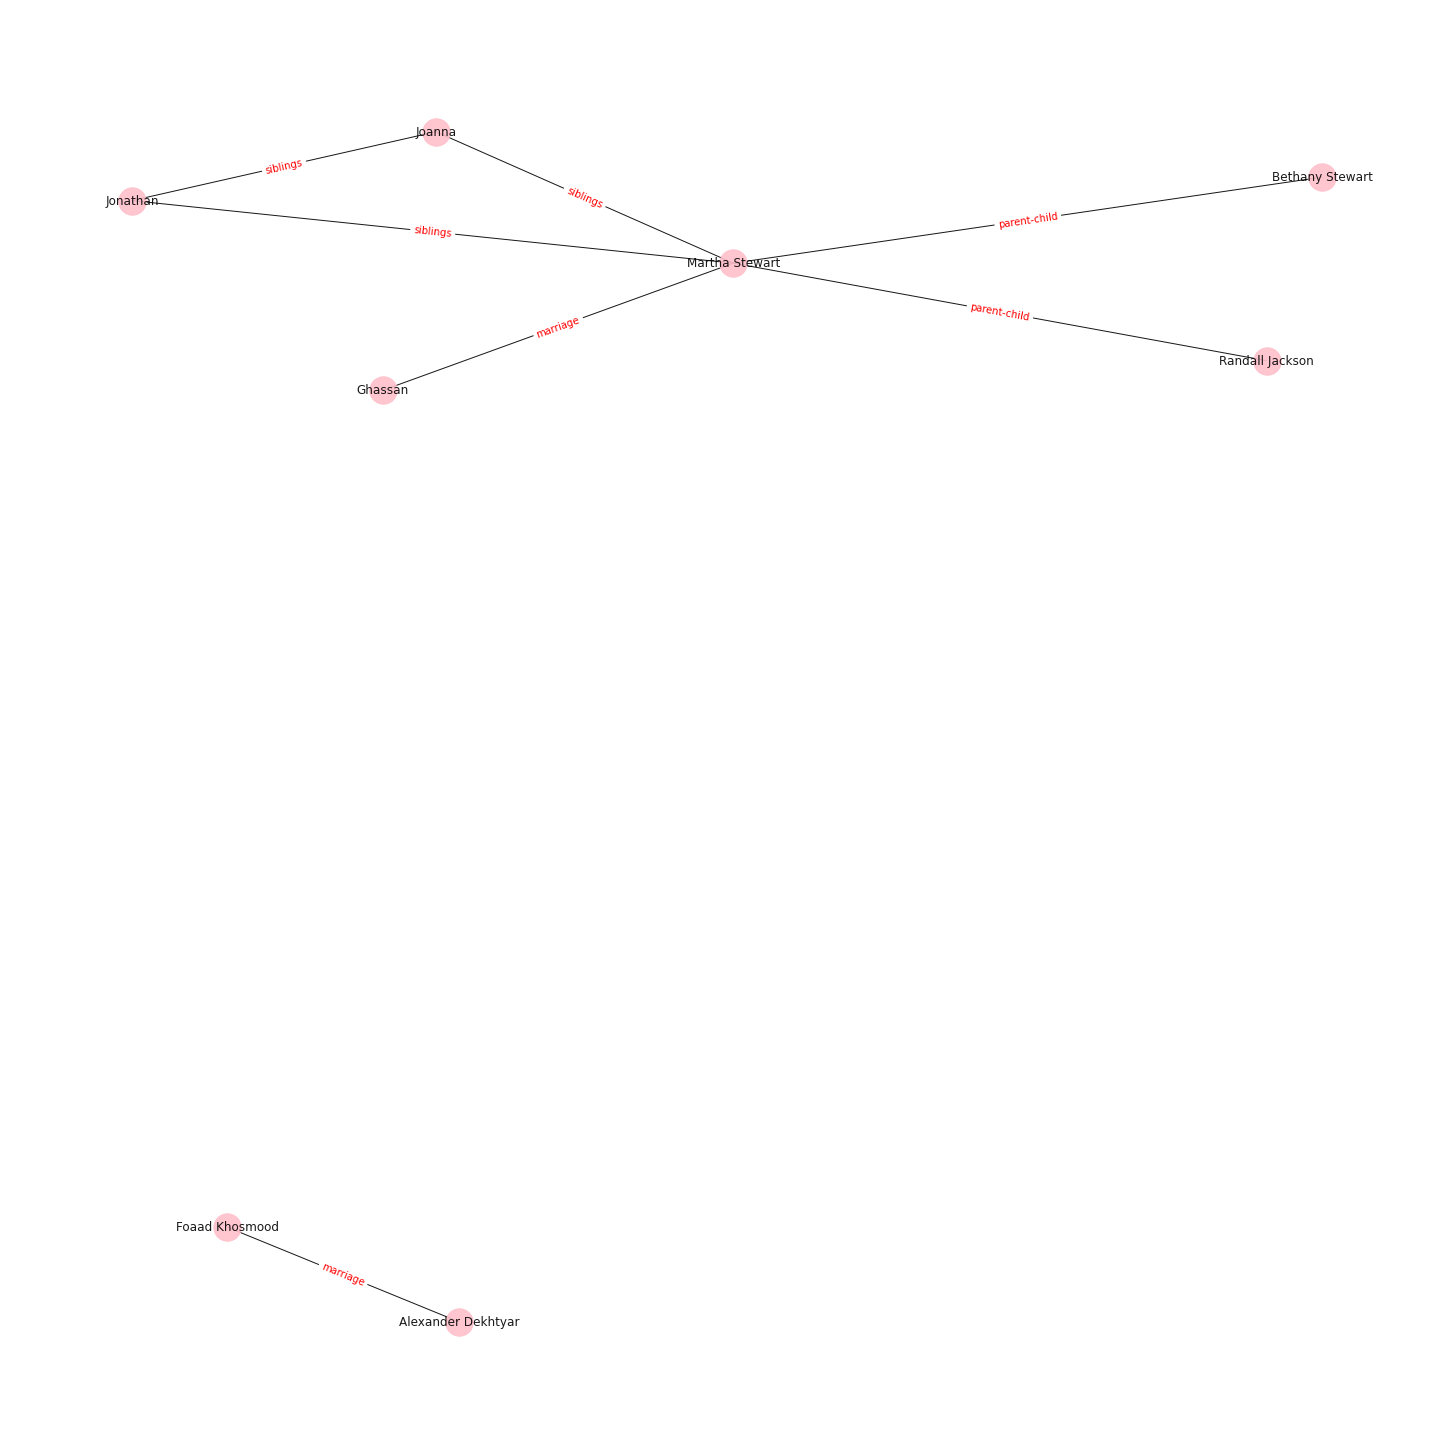

In [301]:
test_paragraph = '''
Guth was born on October 15, 1871, in Nashville, Tennessee, to Rev. George Guth and Susan Sophie Grandlienard of Perrefitte, Switzerland. Guth was of German, French, and Swiss descent.[1] When he was a teenager, his family moved to San Francisco, California. He enrolled at the University of the Pacific and continued his studies at the then-newly established Stanford University, from which he graduated Phi Beta Kappa in 1892.

Following his college graduation, he studied at University of California, Hastings College of the Law and was admitted to the California bar in December 1895. He practiced law in California for several years and then continued his studies at Boston University, earning a Bachelor of Sacred Theology and becoming ordained as a Methodist minister. He briefly served as a pastor before entering academia. Guth married Helen Louise Fischbeck of San Francisco in March 1896. In 1904, he received a doctorate from Halle University in Halle, Germany.[2] Guth's dissertation was titled Die ältere Schicht in den Erzählung über Saul und David.[3]
'''

test_paragraph = '''
Martha Stewart lived in Detroit all of her life when she emigrated from Peru in South America. She has a father named Randall Jackson and a mother named Bethany Stewart. Martha enjoys playing soccer with her sister Joanna and brother Jonathan. The three of them play kickball. Her best friend is Ghassan, although his brother hates Martha so he tries to get him to play with other friends from school, namely Alexander Dekhtyar and Foaad Khosmood.
'''

test = ParagraphPipeline(test_paragraph)
GG = RelGraphBuilder(test, model_pipeline)
GG.draw_graph()

In [279]:
paragraph1 = '''
Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian (née Houghton).[18] She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob.[19] Their mother is of Dutch, English, Irish, and Scottish ancestry,[20] while their father was a third-generation Armenian-American.[21] After their parents divorced in 1991, her mother married again that year, to Bruce Jenner,[a] the 1976 Summer Olympics decathlon winner.[23] Through their marriage, Kim Kardashian gained step-brothers Burton "Burt", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner.[24]
'''

paragraph2 = '''
Bryant was born in Philadelphia,[12] the youngest of three children and the only son of Pamela Cox Bryant and former NBA player Joe Bryant. He was also the maternal nephew of NBA player John "Chubby" Cox.[13] His parents named him after the famous beef of Kobe, Japan, which they saw on a restaurant menu.[14][15] His middle name, Bean, was derived from his father's nickname "Jellybean."[16] Bryant's family was Catholic and he was brought up with this faith.[17][18][19]

Bryant was the youngest of three children. He grew up with two older sisters, Sharia and Shaya, and had a close relationship with them until his death.

The Bryants' first daughter, Natalia, was born in January 2003.[409] The birth resulted in a reconciliation between Bryant and his parents. Due to an ectopic pregnancy, Vanessa suffered a miscarriage in the spring of 2005. Their second daughter, Gianna Maria-Onore (also referred to as "Gigi"), was born in May 2006.[410] On December 16, 2011, Vanessa Bryant filed for divorce, citing irreconcilable differences, and the couple requested joint custody of their daughters.[411][412] On January 11, 2013, Bryant and his wife both announced via social media that they had called off their divorce.[413] In early December 2016, Vanessa gave birth to their third daughter,[414][415][416] and in January 2019 the Bryants announced they were expecting a fourth daughter.[417] Their daughter was born in June 2019.[418][419]
'''

paragraph3 = '''
Walter Bruce Willis[4] was born in Idar-Oberstein, West Germany, on March 19, 1955.[5][6] His mother, Marlene,[7] was German, from Kassel.[5] His father, David Willis, was an American soldier. Willis has a younger sister, Florence, and two younger brothers, Robert (deceased) and David.[8] After being discharged from the military in 1957, his father relocated the family to his hometown of Carneys Point, New Jersey.[9] Willis has described his background as a "long line of blue-collar people".[9] His mother worked in a bank and his father was a welder, master mechanic, and factory worker.[4]
'''

paragraph4 = '''
Maria "Maja" Einstein (18 November 1881 – 25 June 1951) and her older brother, Albert, were the two children of Hermann Einstein and Pauline Einstein (née Koch), who had moved from Ulm to Munich in June 1881, when Albert was one.[14] There Hermann and his brother Jakob had founded Einstein & Cie., an electrical engineering company.[15]
'''

paragraph5 = '''
Bolt was born on 21 August 1986 to parents Wellesley and Jennifer Bolt[10] in Sherwood Content,[17] a small town in Jamaica. He has a brother, Sadiki,[18] and a sister, Sherine.[19][20] His parents ran the local grocery store in the rural area, and Bolt spent his time playing cricket and football in the street with his brother,[21] later saying, "When I was young, I didn't really think about anything other than sports."[22] As a child, Bolt attended Waldensia Primary, where he began showing his sprint potential when he ran in his parish's annual national primary school meet.[1] By the age of twelve, Bolt had become the school's fastest runner over the 100 metres distance.[23] Bolt also developed an affection for European football teams Real Madrid and Manchester United.[15]
'''

paragraph6 = '''
Ashley Michelle Tisdale was born on July 2, 1985 in Monmouth County, New Jersey to Lisa Morris and contractor Michael Tisdale.[2] Her father is Christian and her mother is Jewish; she was raised with "a little bit of both" religions.[3] Tisdale's elder sister Jennifer is an actress and producer.[4] She is also related to businessman Ron Popeil through her maternal grandfather Arnold Morris who was best known for being a pitchman for the Ginsu knife.[2][5] At the age of three, Tisdale met her manager, Bill Perlman, at a New Jersey mall. He sent her to various auditions for commercials, and she was placed in more than one hundred national network TV advertisements as a child.[6] She began her theatrical career by appearing in Gypsy: A Musical Fable and The Sound of Music at Monmouth County's Jewish Community Center.[7]
'''

# paragraph1 = clean_wikitext(paragraph1)
# paragraph2 = clean_wikitext(paragraph2)
# paragraph3 = clean_wikitext(paragraph3)
# paragraph4 = clean_wikitext(paragraph4)
# paragraph5 = clean_wikitext(paragraph5)
# paragraph6 = clean_wikitext(paragraph6)
test_par = '''
Heather Joy Knight was born in Jamaica and lived there for the first nine years of her life.[2] She immigrated to the United States, settling in the Bronx, New York, with her parents Austin and Herolin Evelyn.[2] Knight is married to professor and outreach chaplain, Norman Knight.[3] They have five sons and three daughters.[3]
'''

test = ParagraphPipeline(test_par)
display(test.entity_rels)
GG = RelGraphBuilder(test, model_pipeline)

defaultdict(<function __main__.ParagraphPipeline.__init__.<locals>.<lambda>()>,
            {her: [Heather Joy Knight],
             She: [Heather Joy Knight],
             her: [Heather Joy Knight],
             Knight: [Heather Joy Knight],
             They: [Norman Knight]})

defaultdict(<function __main__.RelGraphBuilder.__init__.<locals>.<lambda>()>,
            {(Herolin Evelyn, Knight): {'label': 'marriage',
              'score': 0.6283432245254517},
             (Herolin Evelyn, her): {'label': 'parent-child',
              'score': 0.8642414808273315},
             (Norman Knight, They): {'label': 'parent-child',
              'score': 0.7986356616020203}})

(Herolin Evelyn, Heather Joy Knight) {'label': 'parent-child', 'score': 0.8642414808273315}
(Norman Knight, Norman Knight) {'label': 'parent-child', 'score': 0.7986356616020203}


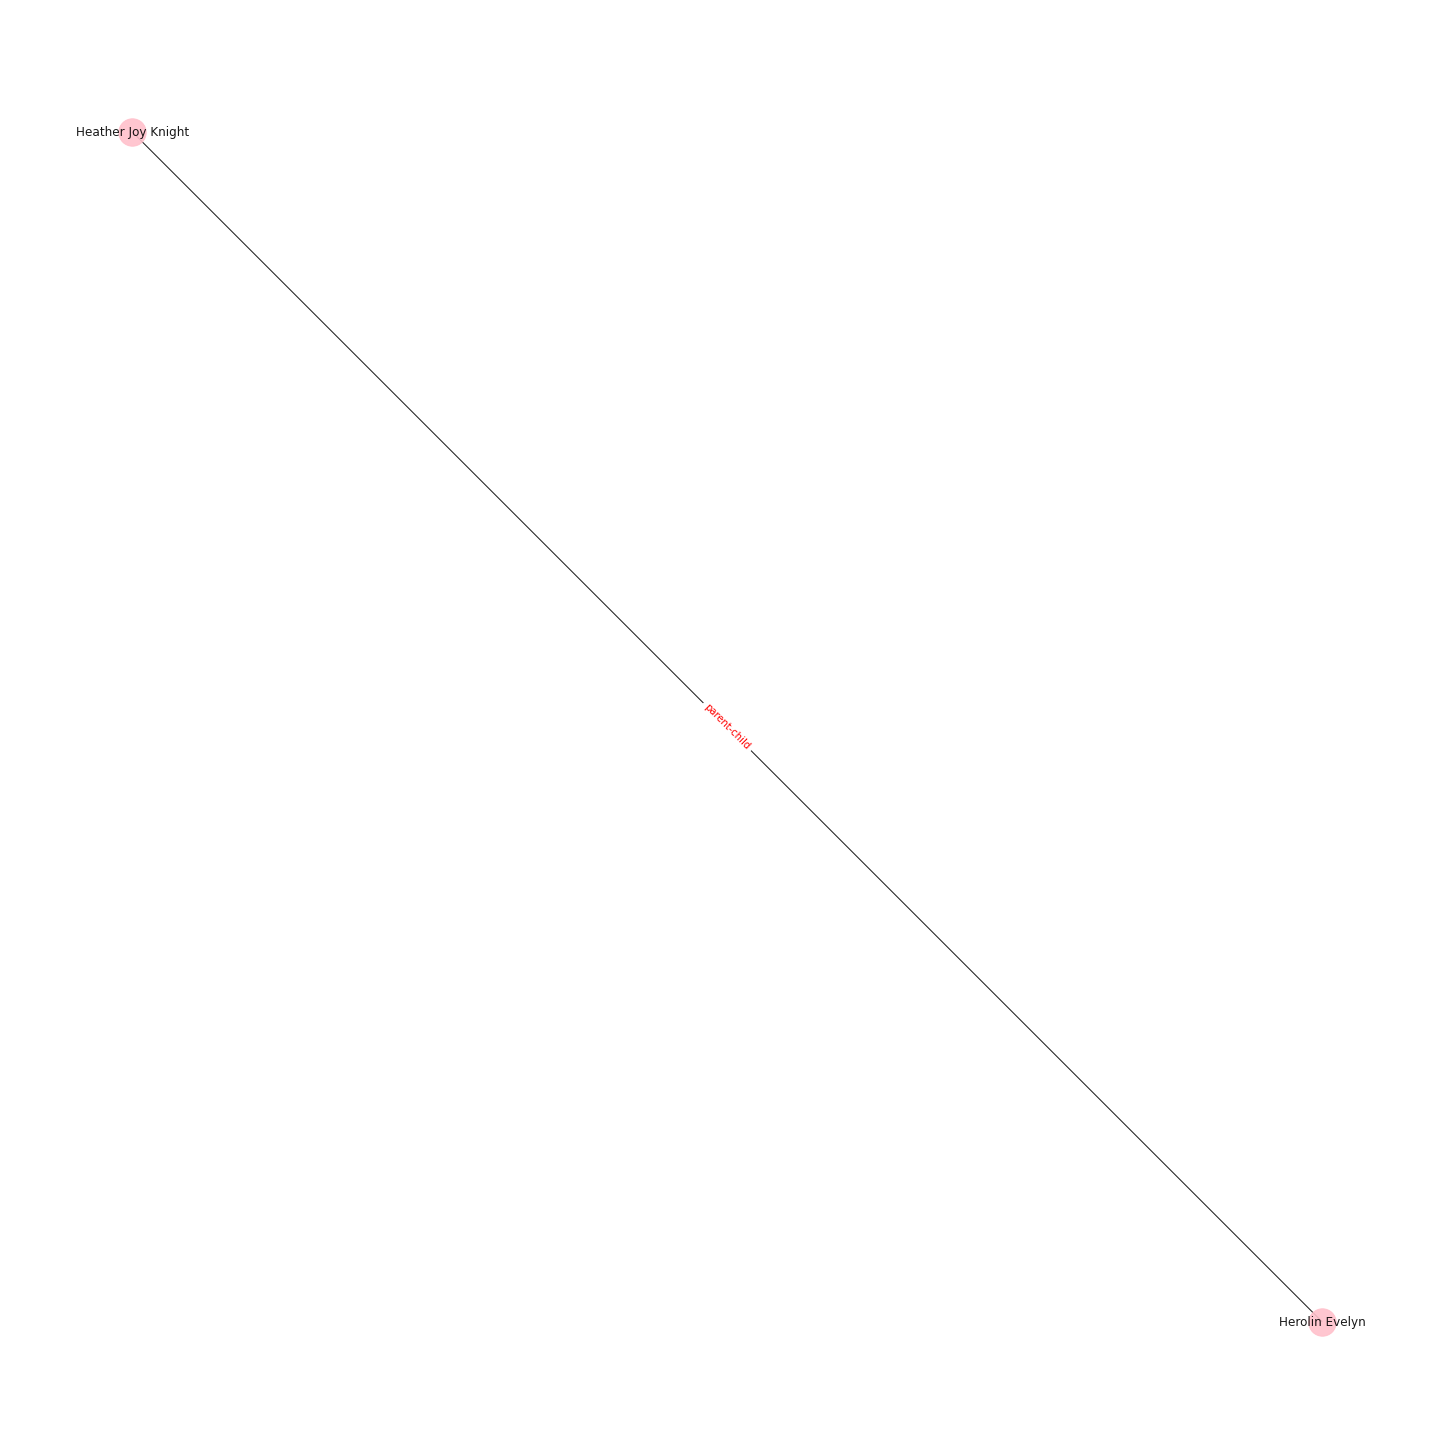

In [280]:
GG.draw_graph()

In [236]:
test.rels

[[N/A] Pamela Cox Bryant ---> Joe Bryant,
 [N/A] Pamela Cox Bryant ---> John "Chubby" Cox,
 [N/A] Joe Bryant ---> John "Chubby" Cox,
 [N/A] Bryant ---> he,
 [N/A] Shaya ---> Natalia,
 [N/A] Shaya ---> he,
 [N/A] Natalia ---> Bryant,
 [N/A] Natalia ---> he,
 [N/A] Bryant ---> Vanessa,
 [N/A] Bryant ---> he,
 [N/A] Vanessa ---> Gianna Maria-Onore,
 [N/A] Vanessa ---> he,
 [N/A] Gianna Maria-Onore ---> Vanessa Bryant,
 [N/A] Gianna Maria-Onore ---> he,
 [N/A] Vanessa Bryant ---> he,
 [N/A] Vanessa ---> he]

In [237]:
GG.e_labels

{(Pamela Cox Bryant, Pamela Cox Bryant): {'label': 'parent-child',
  'score': 0.4845684766769409}}

In [ ]:
list(GG.e_labels.keys())

In [ ]:
test.entity_rels

In [194]:
display(list(GG.e_labels.items()))

[((Maria "Maja" Einstein, Albert),
  {'label': 'parent-child', 'score': 0.7581347823143005}),
 ((Maria "Maja" Einstein, Hermann Einstein),
  {'label': 'parent-child', 'score': 0.9373174905776978}),
 ((Maria "Maja" Einstein, Pauline Einstein),
  {'label': 'parent-child', 'score': 0.8959909677505493}),
 ((Albert, Hermann Einstein),
  {'label': 'parent-child', 'score': 0.9302458167076111}),
 ((Albert, Pauline Einstein),
  {'label': 'parent-child', 'score': 0.9121272563934326}),
 ((Hermann Einstein, Pauline Einstein),
  {'label': 'parent-child', 'score': 0.8612006306648254}),
 ((Albert, Hermann), {'label': 'parent-child', 'score': 0.3581365942955017}),
 ((Hermann, Jakob), {'label': 'siblings', 'score': 0.5889827609062195}),
 ((Hermann, Hermann), {'label': 'siblings', 'score': 0.5581938624382019}),
 ((Jakob, Hermann), {'label': 'siblings', 'score': 0.5736629962921143})]

In [190]:
# for ents, rel in GG.e_labels.items():
#         if rel['label'] != 'no-rel':
#                 GG.G.add_edge(ents[0], ents[1])

# # list(GG.G.nodes())[0] == list(GG.G.nodes())[5]

In [73]:
{node: node.text for node in GG.G.nodes()}

{Marlene: 'Marlene',
 His: 'His',
 David Willis: 'David Willis',
 Robert: 'Robert',
 His: 'His',
 Willis: 'Willis',
 David: 'David'}

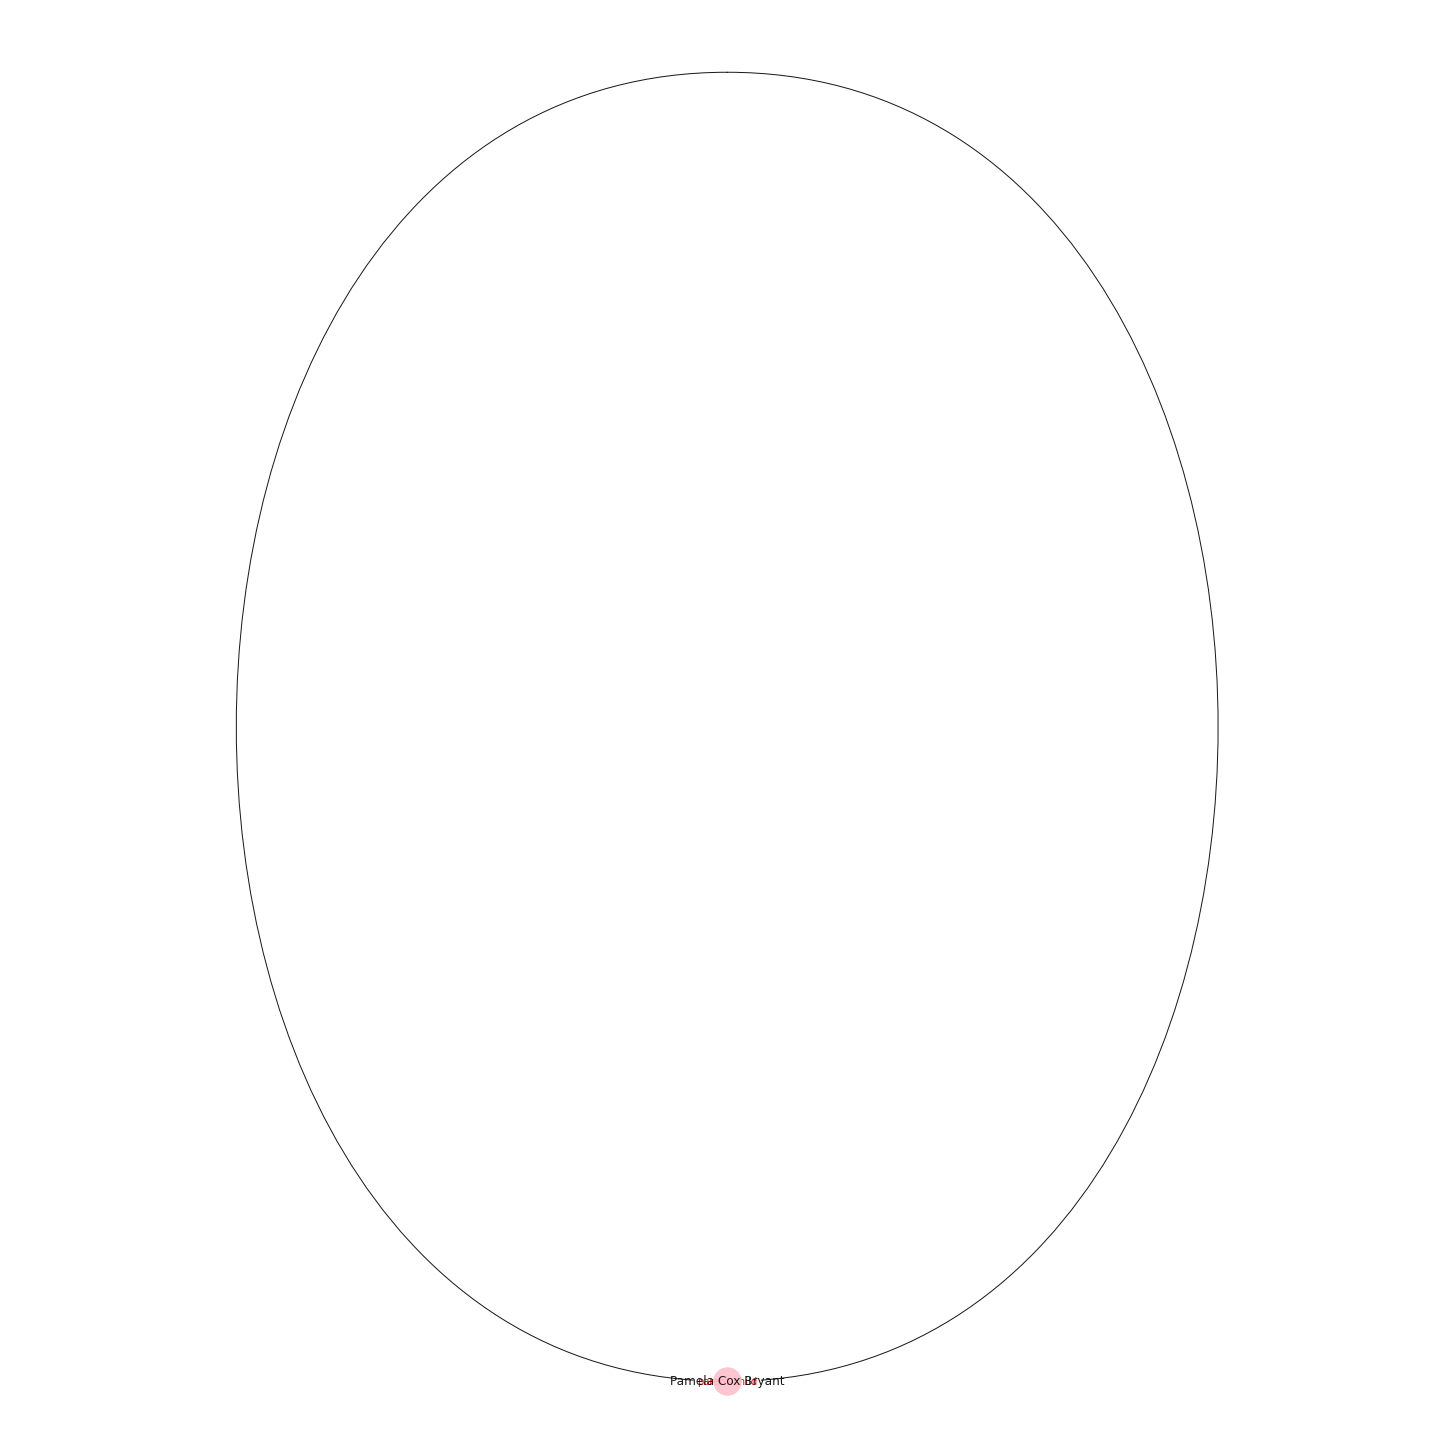

In [235]:
for ents, rel in GG.e_labels.items():
        if rel['label'] != 'no-rel':
                GG.G.add_edge(ents[0], ents[1])

plt.figure(figsize=(20,20))
pos = nx.spring_layout(GG.G)
nx.draw(
    GG.G, pos, edge_color='black', width=1, linewidths=1,
    node_size=750, node_color='pink', alpha=0.9,
    labels={node : node.text for node in GG.G.nodes()}
)
nx.draw_networkx_edge_labels(
    GG.G, pos,
    edge_labels={ents : rel['label'] for ents, rel in GG.e_labels.items()},
    font_color='red'
)

display(GG.G)

In [55]:
from transformers import pipeline, AutoTokenizer
model_pipeline = pipeline(task='text-classification',
                          model=my_model,
                          tokenizer=AutoTokenizer.from_pretrained("bert-base-cased"))

In [217]:
model_pipeline(['[E1] Mary [/E1] is the sister of [E2] Mark [/E2]',
                'Mary is the sister of Mark',
                '[E1] Jonathan [/E1] is the long-lost friend of [E2] Beatrice [/E2]',
                'Quintavius is the long-lost friend of Elizabeth',
                'Smith and [E1] Johnny [/E1] brother [E1] Ethan [/E1] own Treybal'
               ])

[{'label': 'siblings', 'score': 0.5686220526695251},
 {'label': 'no-rel', 'score': 0.8433283567428589},
 {'label': 'marriage', 'score': 0.5537773370742798},
 {'label': 'no-rel', 'score': 0.6881057024002075},
 {'label': 'siblings', 'score': 0.9575772285461426}]

In [ ]:
def clean_wikitext(text):
    cleaned = re.sub(r'\[.{1,3}\]', '', text)
    cleaned = re.sub(r' \(([^\)]*[^\)]*?)\)', '', cleaned)
    return cleaned

MAX_SPAN_LEN = 120

paragraph = '''
Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian (née Houghton).[18] She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob.[19] Their mother is of Dutch, English, Irish, and Scottish ancestry,[20] while their father was a third-generation Armenian-American.[21] After their parents divorced in 1991, her mother married again that year, to Bruce Jenner,[a] the 1976 Summer Olympics decathlon winner.[23] Through their marriage, Kim Kardashian gained step-brothers Burton "Burt", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner.[24]
'''

test_doc = clean_wikitext(paragraph)
test_doc = nlp(test_doc)
ents = get_relevant_annotations(test_doc)
clust_pairs = get_cluster_pairs(test_doc)
clust_dict = defaultdict(lambda: [])
for refers2, coref in clust_pairs:
    for c in coref:
        clust_dict[c].append(refers2)

clust_pairs[0][0][0] in ents
        
# for i in range(len(ents)):
#     for j in range(i + 1, len(ents)):
#         span = test_doc[ents[i].start_char : ents[j].end_char]
#         if len(span) < MAX_SPAN_LEN:
#             print(span)
# print(ents)
# print(clust_pairs)
# print(clust_dict)

In [ ]:
predictions = model_pipeline([r for ents, r in rels])
predictions[:10]

In [ ]:
import networkx as nx
G = nx.Graph()
e_labels = {}

for i in range(len(predictions)):
    if predictions[i]['label'] != 'OTHER' and predictions[i]['score'] > 0.85:
        G.add_edge(rels[i][0][0], rels[i][0][1], edge_label=predictions[i]['label'])
        if (rels[i][0][0], rels[i][0][1]) not in e_labels:
            e_labels[(rels[i][0][0], rels[i][0][1])] = predictions[i]['label']
        
G

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=750, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=e_labels,
    font_color='red'
)

In [315]:
to_combine = [
    [7, 8],
    [9, 10],
    [11, 12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21],
    [22, 23, 24],
    [25, 26],
    [27, 28],
    [32, 33, 34],
    [37, 38, 39, 40, 41, 42, 43],
    [44, 45],
    [46, 47],
    [49, 50],
    [51, 52]   
]

In [376]:
with open('exported.json', 'r') as f:
    data = json.load(f)

final = []
task2dict = {d['id'] : d for d in data}
# task2dict[7]['data']['text']
for docs2combine in to_combine:
    ref = task2dict[docs2combine[0]]
    new_text = ref['data']['text']
    text_len = len(new_text)
    offset = text_len + 2 # 2 newlines + first character
    original_ents = ref['annotations'][0]['result']
    # print(ref['data']['text'])
    for other in docs2combine[1:]:
        other_doc = task2dict[other]
        for ent in other_doc['annotations'][0]['result']:
            if ent['type'] == 'labels':
                ent['value']['start'] += offset
                ent['value']['end'] += offset
            original_ents.append(ent)
        new_text = new_text + '\n\n' + other_doc['data']['text']
        text_len = len(new_text)
        offset = text_len + 2 # 2 newlines
    ref['data']['text'] = new_text
    final.append(copy.deepcopy(ref))
    
# print(ref['data']['text'])

In [377]:
with open('test.json', 'w') as f:
    json.dump(final, f)

In [371]:
final

[{'id': 7,
  'annotations': [{'id': 8,
    'completed_by': 1,
    'result': [{'value': {'start': 0,
       'end': 14,
       'text': 'Schwarzenegger',
       'labels': ['entity']},
      'id': 'Ww3NT0QsfN',
      'from_name': 'label',
      'to_name': 'txt-99',
      'type': 'labels',
      'origin': 'prediction-changed'},
     {'value': {'start': 75, 'end': 80, 'text': 'Arnie', 'labels': ['entity']},
      'id': 'JTZ1y-n_s1',
      'from_name': 'label',
      'to_name': 'txt-99',
      'type': 'labels',
      'origin': 'prediction-changed'},
     {'value': {'start': 184,
       'end': 197,
       'text': 'Maria Shriver',
       'labels': ['entity']},
      'id': 'ACHTjDkouP',
      'from_name': 'label',
      'to_name': 'txt-99',
      'type': 'labels',
      'origin': 'prediction-changed'},
     {'value': {'start': 220,
       'end': 235,
       'text': 'John F. Kennedy',
       'labels': ['entity']},
      'id': 'Y9hp5gkSeZ',
      'from_name': 'label',
      'to_name': 'txt-99',
  